How to use a reconstruction autoencoder to detect anomalies in timeseries data:

In [1]:
import numpy as np
import pandas as pd
import keras
from keras import layers
import matplotlib.pyplot as plt

**Load the Data:**
- dataset with artificial timeseries data => containing labeled anomalous periods of behaviour - Data are ordered, timestamped, singlevalued metrics.

In [2]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"
df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

In [3]:
df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

Quick look at the data:

In [4]:
print(df_small_noise.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120


In [8]:
print(df_small_noise.tail())

                         value
timestamp                     
2014-04-14 23:35:00  20.211195
2014-04-14 23:40:00  20.531041
2014-04-14 23:45:00  19.032127
2014-04-14 23:50:00  21.798801
2014-04-14 23:55:00  18.682620


In [5]:
print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


Visualize the data:
- Timeseries without anomalies
- we use the following data for training

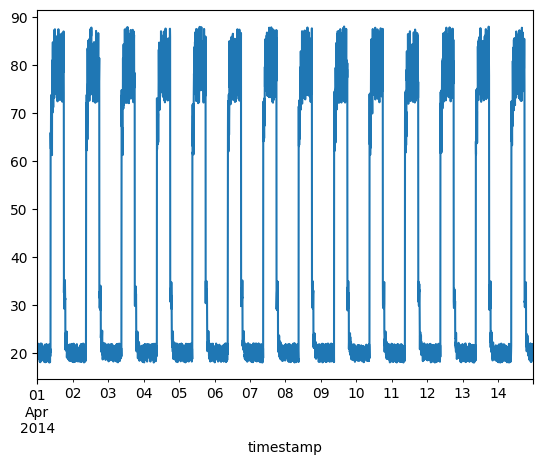

In [6]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

Timeseries with anomalies:

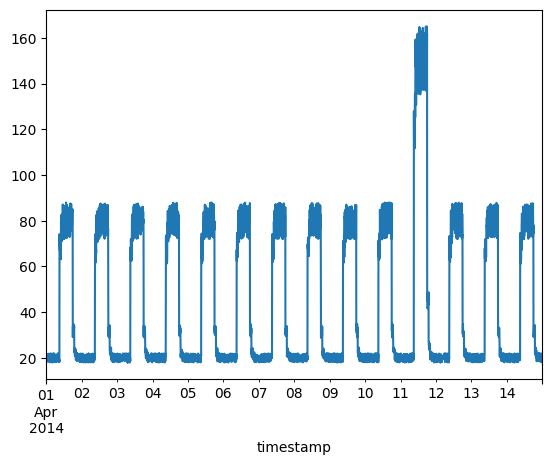

In [7]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

**Prepare the training data:**
- get data values from the training timeseries data file and normalize the valie data. We have a value for every 5 mins for 14 days.
- 24*60/5 = 288 timesteps per day
- 288*14 = 4032 data points in total

In [9]:
# normalize and save the mean and std we get,
# for normalizing the test data

training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise-training_mean)/training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


Create sequences

In [11]:
len(df_training_value.values) - 288 + 1

3745

In [40]:
df_training_value.shape

(4032, 1)

In [12]:
TIME_STEPS = 288

# Genereated training sequences for use in the model
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1): # take off a day's worth of data cuz we'll get it in the last loop
        output.append(values[i : (i+time_steps)])
    return np.stack(output)

x_train = create_sequences(df_training_value.values)

In [13]:
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


Build a model:
- We will now build a convolutional reconstruction autoencoder model. The model will take input of shape (batch size, sequence length, num features) - and return output of the same shape. Sequence length is 288 - and num features is 1.

In [14]:
model = keras.Sequential([
    layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
    layers.Conv1D(
        filters=32,
        kernel_size=7,
        padding="same",
        strides=2,
        activation="relu"
    ),
    layers.Dropout(0.2),
    layers.Conv1D(
        filters=16,
        kernel_size=7,
        padding="same",
        strides=2,
        activation="relu"
    ),
    layers.Conv1DTranspose(
        filters=16,
        kernel_size=7,
        padding="same",
        strides=2,
        activation="relu"
    ),
    layers.Dropout(rate=0.2),
    layers.Conv1DTranspose(
        filters=32,
        kernel_size=7,
        padding="same",
        strides=2,
        activation="relu"
    ),
    layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same")

])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 144, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 144, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 72, 16)         │         3,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 144, 16)        │         1,808 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 144, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 288, 32)        │         3,616 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 288, 1)         │           225 │
│ (Conv1DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,505 (37.13 KB)

 Trainable params: 9,505 (37.13 KB)

 Non-trainable params: 0 (0.00 B)

Train the model:

In [15]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ]
)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.8454 - val_loss: 0.1341
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1099 - val_loss: 0.0443
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0625 - val_loss: 0.0367
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0528 - val_loss: 0.0324
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0460 - val_loss: 0.0294
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0408 - val_loss: 0.0279
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0363 - val_loss: 0.0257
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0330 - val_loss: 0.0243
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0299 - val_loss: 0.0239
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0276 - val_loss: 0.0248
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0258 - val_loss: 0.0261
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0

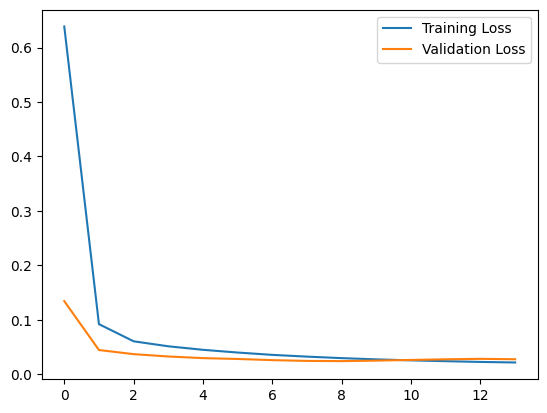

In [16]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

**Detecting Anomalies:**
- We detech anomalies by determining how well our model can reconstruct the input data
  1. Find MAE loss on training samples
  2. Find max MAE loss value. This is the worst the model has performed trying to reconstruct a sample. We make thos the threshold for anomaly detection
  3. If the reconstruction loss for a sample is greater than this threshold - we can infer that the the model is seeing a pattern that it isn't familiar with. we label this pattern as an anomaly. 

In [17]:
x_train.shape

(3745, 288, 1)

In [18]:
# get the train mae loss
x_train_pred = model.predict(x_train)

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [19]:
x_train_pred.shape

(3745, 288, 1)

In [20]:
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

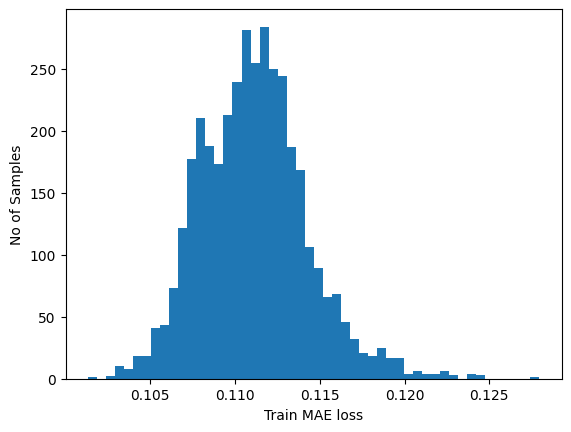

In [23]:
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of Samples")
plt.show()

In [24]:
# get the reconstruction loss threshold
threshold = np.max(train_mae_loss)
print("reconstruction error threshold: ", threshold)

reconstruction error threshold:  0.12793843518744857


Just for fun - let's visualize how our model reconstructed the first sample

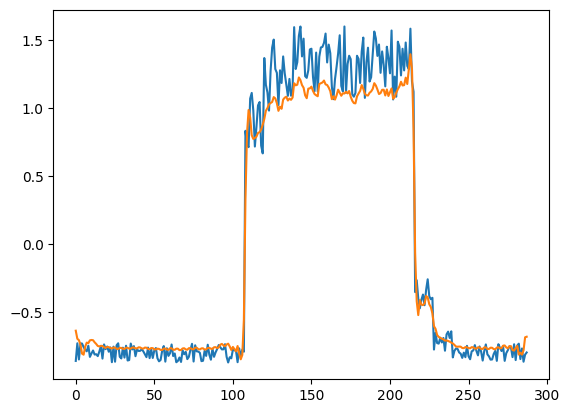

In [25]:
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

**prepare the test data:**

In [26]:
df_test_value = (df_daily_jumpsup - training_mean)/training_std

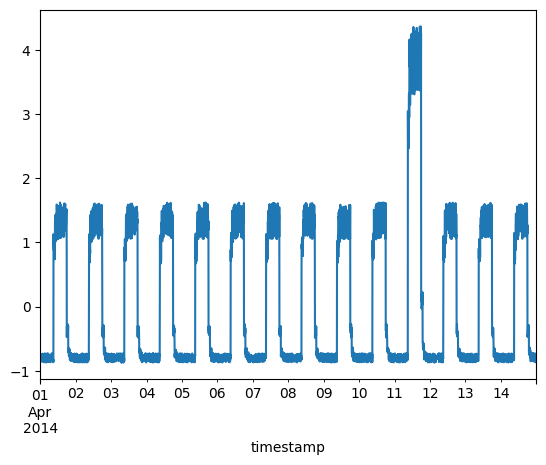

In [27]:
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

In [28]:
# create sequences from test values
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

Test input shape:  (3745, 288, 1)


In [29]:
# get the mae loss:
x_test_pred = model.predict(x_test)

118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [30]:
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

In [31]:
test_mae_loss.shape

(3745, 1)

In [32]:
test_mae_loss = test_mae_loss.reshape((-1))

In [34]:
test_mae_loss.shape

(3745,)

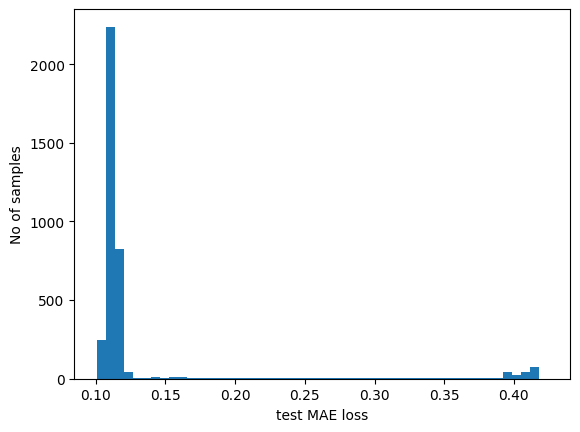

In [35]:
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [36]:
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  395
Indices of anomaly samples:  (array([2517, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711,
       2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722,
       2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733,
       2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744,
       2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755,
       2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766,
       2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777,
       2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788,
       2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799,
       2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810,
       2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821,
       2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832,
       2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2

In [37]:
test_mae_loss.shape

(3745,)

Plot the anomalies:
- 

All except the intial and final timesteps - 1 data values - will appear in time_steps number of samples. So - if we know that the samples => [(3, 4, 5), (4, 5, 6)]

In [41]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

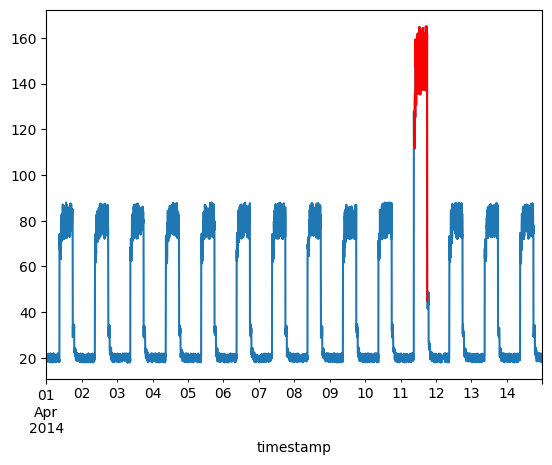

In [42]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

Credit: [Keras Example](https://keras.io/examples/timeseries/timeseries_anomaly_detection/)